In [1]:
cd D:/haris/BiasCorr

D:\haris\BiasCorr


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import probscale
import scipy
import seaborn as sns
import xarray as xr
import warnings
import zarr
warnings.filterwarnings("ignore")  # sklearn

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

from utils import get_sample_data

sns.set(style='darkgrid')

training               targets          
                 tmax           pcp    tmax       pcp
time                                                 
1950-01-01        NaN           NaN   -0.22  5.608394
1950-01-02        NaN           NaN   -4.54  2.919726
1950-01-03        NaN           NaN   -7.87  3.066762
1950-01-04        NaN           NaN   -5.08  4.684164
1950-01-05        NaN           NaN   -0.79  4.295568
...               ...           ...     ...       ...
2015-11-26   7.657013  0.000000e+00     NaN       NaN
2015-11-27   7.687256  0.000000e+00     NaN       NaN
2015-11-28  10.480835  0.000000e+00     NaN       NaN
2015-11-29  11.728516  0.000000e+00     NaN       NaN
2015-11-30  10.285431  3.152419e-13     NaN       NaN

[24075 rows x 4 columns]

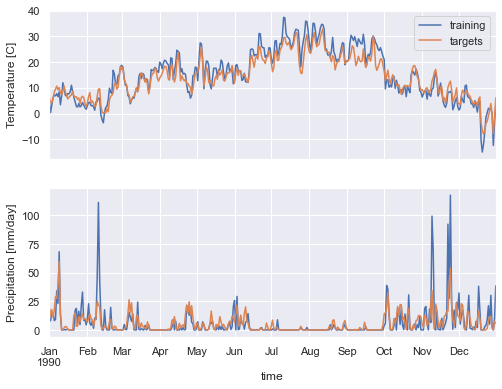

In [3]:
# load sample data
training = get_sample_data('training')
targets = get_sample_data('targets')

# print a table of the training/targets data
display(pd.concat({'training': training, 'targets': targets}, axis=1))

# make a plot of the temperature and precipitation data
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(8, 6), sharex=True)
time_slice = slice('1990-01-01', '1990-12-31')

# plot-temperature
training[time_slice]['tmax'].plot(ax=axes[0], label='training')
targets[time_slice]['tmax'].plot(ax=axes[0], label='targets')
axes[0].legend()
axes[0].set_ylabel('Temperature [C]')

# plot-precipitation
training[time_slice]['pcp'].plot(ax=axes[1])
targets[time_slice]['pcp'].plot(ax=axes[1])
_ = axes[1].set_ylabel('Precipitation [mm/day]')

In [4]:
#import sklearn
#from sklearn.linear_model.base import LinearRegression
from sklearn.linear_model._base import LinearRegression
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble._base import RandomForestRegressor


from skdownscale.pointwise_models import PureAnalog, AnalogRegression
from skdownscale.pointwise_models import BcsdTemperature, BcsdPrecipitation


models = {
    'GARD: PureAnalog-best-1': PureAnalog(kind='best_analog', n_analogs=1),
    'GARD: PureAnalog-sample-10': PureAnalog(kind='sample_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-10': PureAnalog(kind='weight_analogs', n_analogs=10),
    'GARD: PureAnalog-weight-100': PureAnalog(kind='weight_analogs', n_analogs=100),
    'GARD: PureAnalog-mean-10': PureAnalog(kind='mean_analogs', n_analogs=10),
    'GARD: AnalogRegression-100': AnalogRegression(n_analogs=100),
    'GARD: LinearRegression': LinearRegression(),
    'BCSD: BcsdTemperature': BcsdTemperature(return_anoms=False),
    'Sklearn: RandomForestRegressor': RandomForestRegressor(random_state=0)
}

train_slice = slice('1980-01-01', '1989-12-31')
predict_slice = slice('1990-01-01', '1999-12-31')

In [5]:
# extract training / prediction data
X_train = training[['tmax']][train_slice]
y_train = targets[['tmax']][train_slice]
X_predict = training[['tmax']][predict_slice]

# Fit all models
for key, model in models.items():
    model.fit(X_train, y_train)

In [6]:
# store predicted results in this dataframe
predict_df = pd.DataFrame(index = X_predict.index)

for key, model in models.items():
    predict_df[key] = model.predict(X_predict)

# show a table of the predicted data
display(predict_df.head())

,GARD: PureAnalog-best-1,GARD: PureAnalog-sample-10,GARD: PureAnalog-weight-10,GARD: PureAnalog-weight-100,GARD: PureAnalog-mean-10,GARD: AnalogRegression-100,GARD: LinearRegression,BCSD: BcsdTemperature,Sklearn: RandomForestRegressor
time,,,,,,,,,
1990-01-01,4.50,5.67,5.375299,5.697786,5.895,5.931445,5.781472,4.528703,5.2024
1990-01-02,6.13,2.56,3.543398,3.264698,2.561,2.515919,2.524322,-1.584749,4.6935
1990-01-03,5.46,5.46,4.963575,4.933534,4.692,4.862730,4.944167,2.848937,4.6736
1990-01-04,8.57,5.08,8.369125,8.239455,7.340,7.255379,7.107427,6.687826,8.4134
1990-01-05,5.67,7.50,7.424970,7.583703,7.705,7.711861,7.878299,8.296425,6.5789


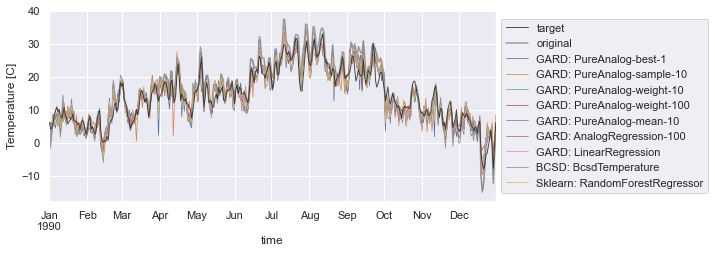

In [7]:
fig, ax = plt.subplots(figsize=(8, 3.5))
targets['tmax'][time_slice].plot(ax=ax, label='target', c='k', lw=1, alpha=0.75, legend=True, zorder=10)
X_predict['tmax'][time_slice].plot(label='original', c='grey', ax=ax, alpha=0.75, legend=True)
predict_df[time_slice].plot(ax=ax, lw=0.75)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
_ = ax.set_ylabel('Temperature [C]')

In [8]:
# calculate r2
score = (predict_df.corrwith(targets.tmax[predict_slice]) **2).sort_values().to_frame('r2_score')
display(score)

,r2_score
GARD: PureAnalog-sample-10,0.819186
GARD: PureAnalog-best-1,0.820281
BCSD: BcsdTemperature,0.858258
Sklearn: RandomForestRegressor,0.864160
GARD: PureAnalog-weight-10,0.881287
GARD: PureAnalog-weight-100,0.892049
GARD: PureAnalog-mean-10,0.899297
GARD: AnalogRegression-100,0.906217
GARD: LinearRegression,0.906316


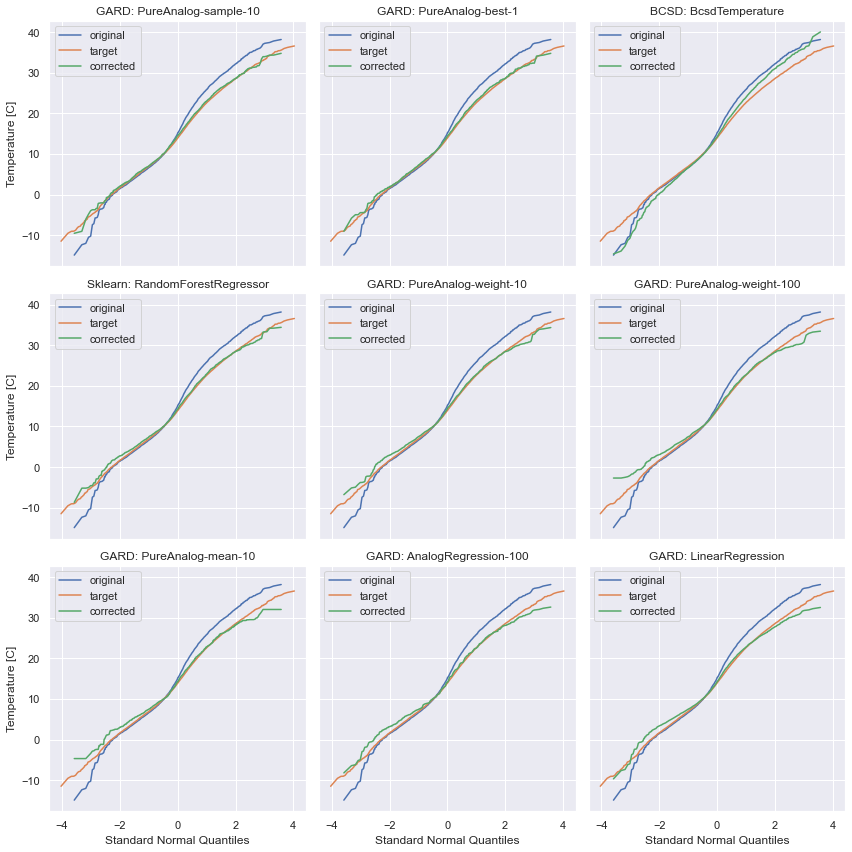

In [9]:
from utils import prob_plots

fig = prob_plots(X_predict, targets['tmax'], predict_df[score.index.values], shape=(3, 3), figsize=(12, 12))

In [10]:
from skdownscale.pointwise_models import ZScoreRegressor

In [11]:
# open a small dataset
training = get_sample_data('wind-hist')
target = get_sample_data('wind-obs')
future = get_sample_data('wind-rcp')

In [12]:
# bias correction using ZScoreRegresssor
zscore = ZScoreRegressor()
zscore.fit(training, target)
fit_stats = zscore.fit_stats_dict_
out = zscore.predict(future)
predict_stats = zscore.predict_stats_dict_

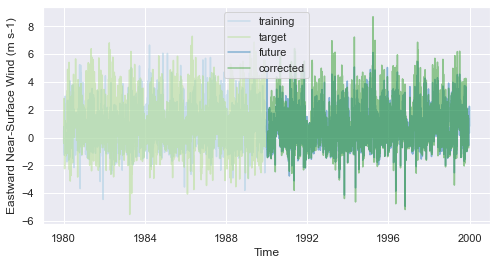

In [13]:
# visualize the datasets
from utils import zscore_ds_plot

zscore_ds_plot(training, target, future, out)

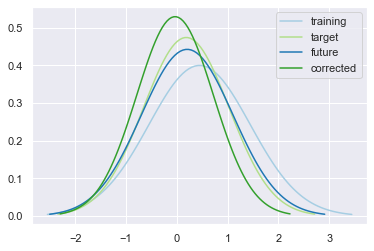

In [14]:
from utils import zscore_correction_plot

zscore_correction_plot(zscore)

In [15]:
# parameters
train_slice = slice('1980', '1982')  # train time range
holdout_slice = slice('1990', '1991')  # prediction time range

# bounding box of downscaling region
lon_slice = slice(-124.8, -120.0) 
lat_slice = slice(50, 45)

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [16]:
from dask.distributed import Client

client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.88 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54245,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.88 GiB
Comm: tcp://127.0.0.1:54283,Total threads: 1
Dashboard: http://127.0.0.1:54287/status,Memory: 1.97 GiB
Nanny: tcp://127.0.0.1:54250,


<xarray.DataArray 'air_temperature' (time: 1096, lat: 106, lon: 115)>
dask.array<xarray-<this-array>, shape=(1096, 106, 115), dtype=float32, chunksize=(1096, 10, 10), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 1982-12-31
  * lat      (lat) float64 49.4 49.36 49.32 49.28 ... 45.15 45.11 45.07 45.03
  * lon      (lon) float64 -124.8 -124.7 -124.7 -124.6 ... -120.1 -120.1 -120.0

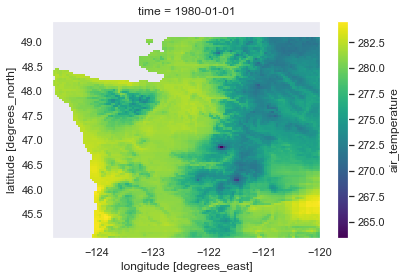

In [17]:
import xarray as xr

fnames = [f'http://thredds.northwestknowledge.net:8080/thredds/dodsC/MET/tmmx/tmmx_{year}.nc'
          for year in range(int(train_slice.start), int(train_slice.stop) + 1)]
# open the data and cleanup a bit of metadata
obs = xr.open_mfdataset(fnames, engine='netcdf4', concat_dim='day').rename({'day': 'time'}).drop('crs')

obs_subset = obs['air_temperature'].sel(time=train_slice, lon=lon_slice, lat=lat_slice).resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(obs_subset)
obs_subset.isel(time=0).plot()

In [18]:
import intake_esm
intake_esm.__version__

'2021.8.17'

In [18]:
import intake

# search the cmip6 catalog
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
cat = col.search(experiment_id=['historical', 'ssp585'], table_id='day', variable_id='tasmax',
                 grid_label='gn')

# access the data and do some cleanup
ds_model = cat['CMIP.NASA-GISS.GISS-E2-1-G.historical.day.gn'].to_dask().squeeze(drop=True).drop(['height', 'lat_bnds', 'lon_bnds', 'time_bnds'])
ds_model.lon.values[ds_model.lon.values > 180] -= 360
ds_model = ds_model.roll(lon=72, roll_coords=True)

# regional subsets, ready for downscaling
train_subset = ds_model['tasmax'].sel(time=train_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
train_subset['time'] = train_subset.indexes['time'].to_datetimeindex()
train_subset = train_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

holdout_subset = ds_model['tasmax'].sel(time=holdout_slice).interp_like(obs_subset.isel(time=0, drop=True), method='linear')
holdout_subset['time'] = holdout_subset.indexes['time'].to_datetimeindex()
holdout_subset = holdout_subset.resample(time='1d').mean().load(scheduler='threads').chunk(chunks)

# display
display(train_subset)
train_subset.isel(time=0).plot()

KeyError: 45.025000000000006

In [ ]:
from skdownscale.pointwise_models import PointWiseDownscaler
from dask.diagnostics import ProgressBar

model = PointWiseDownscaler(BcsdTemperature(return_anoms=False))
model

In [ ]:
model.fit(train_subset, obs_subset)
display(model, model._models)

In [23]:
predicted = model.predict(holdout_subset)
#predicted.drop_vars('member_id')
#predicted.drop_dims(member_id, *, errors='raise')
predicted

,Array,Chunk
Bytes,67.89 MiB,570.31 kiB
Shape,"(730, 2, 106, 115)","(730, 2, 10, 10)"
Count,4224 Tasks,132 Chunks
Type,float32,numpy.ndarray


In [24]:
display(predicted)
predicted.isel(time=0).plot()


,Array,Chunk
Bytes,67.89 MiB,570.31 kiB
Shape,"(730, 2, 106, 115)","(730, 2, 10, 10)"
Count,4224 Tasks,132 Chunks
Type,float32,numpy.ndarray


ValueError: Dimensions {'member_id'} do not exist. Expected one or more of ('time', 'lat', 'lon')